# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Структура проекта:

* Загрузка данных
* Подготовка данных
* Обучение моделей
* Анализ моделей


## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/data/autos.csv')

Mounted at /content/gdrive


## Подготовка данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Большую часть времени посвятим предобработке, связанной с нулевыми или пропущенными значениями. 

In [4]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [7]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: datecreated, dtype: object

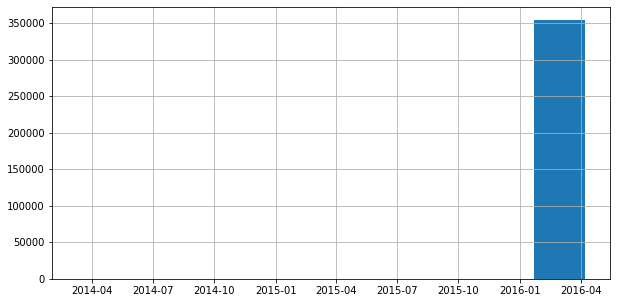

In [8]:
df['datecreated'] = pd.to_datetime(df['datecreated'])
df['datecreated'].hist(figsize=(10,5))
df['datecreated'].describe()

большинство данных анкеты было сделано март-апрель 2016. очевидно, что нам предоставили данные примерно за месяц

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                  354369
unique                 271174
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: datecrawled, dtype: object

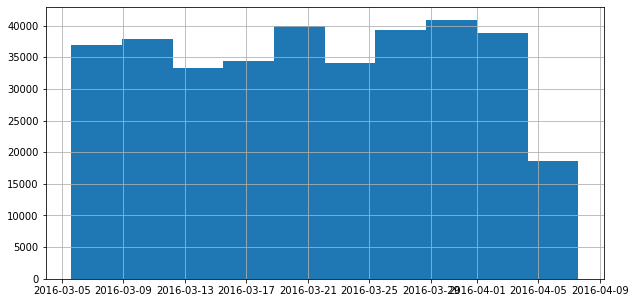

In [9]:
df['datecrawled'] = pd.to_datetime(df['datecrawled'])
df['datecrawled'].hist(figsize=(10,5))
df['datecrawled'].describe()

данные по скачиванию анкеты за месяц с падением к концу. распределены примерно равномерно

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                  354369
unique                 179150
top       2016-04-06 13:45:54
freq                       17
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: lastseen, dtype: object

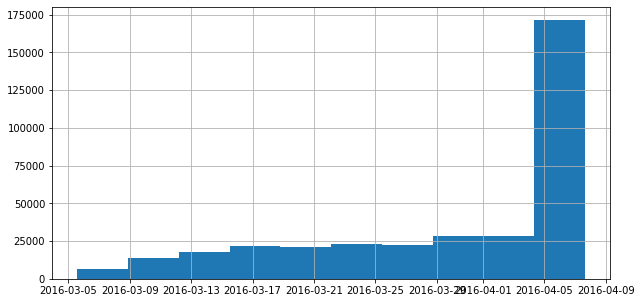

In [10]:
df['lastseen'] = pd.to_datetime(df['lastseen'])
df['lastseen'].hist(figsize=(10,5))
df['lastseen'].describe()

последняя активность за месяц

думаю, в данном случае признаки, связанные со временем стоит удалить, тк существенного влияния на обучение они не окажут. слишком маленький период для существенного изменения в цене на авто

In [11]:
df = df.drop(columns=['datecreated', 'datecrawled', 'lastseen'])
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437


count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

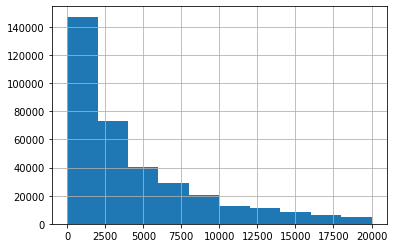

In [12]:
display(df['price'].describe())
df['price'].hist()

исследовали значения по цене

In [13]:
df[df['price']==0]['price'].count()

10772

In [14]:
10772 / 354369

0.030397692800442477

In [15]:
df = df[df['price'] != 0]
df[df['price']==0]['price'].count()

0

цена - целевой признак. удалим нули, они явно тут не нужны.

In [16]:
df['registrationyear'].describe()

count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

видим наличие мусорных значений, попробуем очистить от явных выбросов

In [17]:
np.percentile(df['registrationyear'], [1,99])

array([1980., 2018.])

In [18]:
df = df[df['registrationyear'] >= 1980]
df = df[df['registrationyear'] <= 2016]
df['registrationyear'].describe()

count    326652.000000
mean       2002.913719
std           6.029333
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registrationyear, dtype: float64

In [19]:
df['brand'].value_counts()

volkswagen        70312
opel              36379
bmw               34641
mercedes_benz     29934
audi              27594
ford              23235
renault           16391
peugeot           10398
fiat               8692
seat               6355
skoda              5281
mazda              5250
smart              4965
citroen            4742
nissan             4618
toyota             4384
hyundai            3397
mini               3051
volvo              3005
mitsubishi         2816
honda              2587
kia                2306
suzuki             2202
sonstige_autos     2140
alfa_romeo         2106
chevrolet          1564
chrysler           1305
dacia               865
daihatsu            749
subaru              715
porsche             671
jeep                605
daewoo              505
land_rover          504
saab                500
jaguar              474
rover               432
lancia              423
trabant             371
lada                188
Name: brand, dtype: int64

Далее подход будет идентичен к каждой колонке, в которой есть пропуски: определим наиболее частые значения в столбце и ими будем заполнять пропуски, соотнося со значением

In [20]:
df['model'].isna().sum()

14910

In [21]:
df[df['model'].isna()].sample(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
9442,6600,wagon,2015,manual,75,NaN,30000,3,petrol,dacia,no,0,46459
350340,1420,wagon,1999,manual,0,NaN,150000,0,petrol,volkswagen,NaN,0,13585
39085,1000,small,1998,manual,102,NaN,150000,5,NaN,mercedes_benz,NaN,0,26316
103505,600,NaN,2000,manual,105,NaN,150000,5,NaN,bmw,no,0,75031
181524,3299,other,2001,auto,99,NaN,100000,10,petrol,mercedes_benz,NaN,0,87435


In [22]:
top_model = df.groupby(['brand'])['model'].agg(pd.Series.mode).to_frame()
top_model.columns = ['top_model']
top_model = top_model.reset_index()
top_model.head()

,brand,top_model
0,alfa_romeo,156
1,audi,a4
2,bmw,3er
3,chevrolet,other
4,chrysler,other


In [23]:
df= df.merge(top_model, how='left')
df['model']=df['model'].fillna(df.top_model)
df['model']=df['model'].astype('str')
df['model'].isna().sum()

0

In [24]:
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode,top_model
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435,golf
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954,a4


In [25]:
df=df.drop(columns='top_model')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954


In [26]:
df['vehicletype'].isna().sum()

19681

In [27]:
df[df['vehicletype'].isna()].sample(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
324611,2350,NaN,2005,manual,97,megane,125000,8,NaN,renault,NaN,0,36124
890,250,NaN,2000,NaN,60,fiesta,60000,0,NaN,ford,NaN,0,47475
41031,550,NaN,2016,manual,90,golf,150000,1,NaN,volkswagen,no,0,53639
185906,3500,NaN,2016,manual,90,golf,150000,4,NaN,volkswagen,no,0,15566
248062,850,NaN,2016,manual,0,other,125000,0,petrol,toyota,NaN,0,89362


In [28]:
df['vehicletype'].value_counts()

sedan          88354
small          77735
wagon          63596
bus            28219
convertible    19448
coupe          15070
suv            11616
other           2933
Name: vehicletype, dtype: int64

заменим пропуски по самым частым маркам и моделям

In [29]:
vehicle_mode = df.groupby(['brand', 'model'])['vehicletype'].agg(pd.Series.mode).to_frame()
vehicle_mode.columns = ['vehicle_mode']
vehicle_mode = vehicle_mode.reset_index()
vehicle_mode.head()

,brand,model,vehicle_mode
0,alfa_romeo,145,small
1,alfa_romeo,147,sedan
2,alfa_romeo,156,sedan
3,alfa_romeo,159,wagon
4,alfa_romeo,other,coupe


In [30]:
df = df.merge(vehicle_mode, how='left')

заменим пропуски на самые часты для марки и модели

In [31]:
df['vehicletype'] = df['vehicletype'].fillna(df.vehicle_mode)
df['vehicletype'] = df['vehicletype'].astype('str')
df[df['vehicletype'].isna()]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode,vehicle_mode


In [32]:
df = df.drop(columns='vehicle_mode')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954


In [33]:
df['gearbox'].value_counts()

manual    249219
auto       62379
Name: gearbox, dtype: int64

In [34]:
df['gearbox'].isna().sum()

15054

In [35]:
gearbox_mode = df.groupby(['brand', 'model'])['gearbox'].agg(pd.Series.mode).to_frame()
gearbox_mode.columns = ['gearbox_mode']
gearbox_mode = gearbox_mode.reset_index()
gearbox_mode[gearbox_mode['gearbox_mode'].isna()]

,brand,model,gearbox_mode


In [36]:
df = df.merge(gearbox_mode, how='left')

In [37]:
df['gearbox'] = df['gearbox'].fillna(df.gearbox_mode)
df['gearbox'] = df['gearbox'].astype('str')
df['gearbox'].isna().sum()

0

In [38]:
df = df.drop(columns='gearbox_mode')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954


In [39]:
df['power'].describe()

count    326652.000000
mean        112.221186
std         183.348304
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

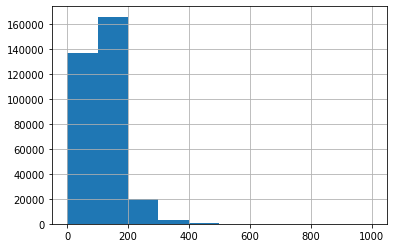

In [40]:
df['power'].hist(range=(0,1000))

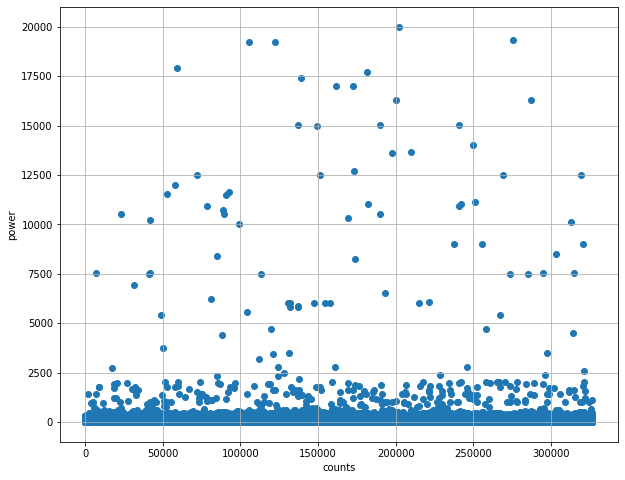

In [41]:
x_values = pd.Series(range(0, len(df)))
fig , ax = plt.subplots(figsize=(10,8))
ax.scatter(x= x_values, y=df['power'])
plt.xlabel('counts')
plt.ylabel('power')
plt.grid()
plt.show()

Очевидно, что очень немного машин приблизится по мощности к 1000лс и уж тем более крайне мало экземпляром будет больше 1000. Все , что больше 1000лс, удаляем. Остальные значения заполним привычным способом через медиану 

In [42]:
len(df[df['power']>1000])/len(df)

0.0007898313801844165

In [43]:
df = df[df['power']<1000]

In [44]:
len(df[df['power']==0])/len(df)

0.09794387712896495

In [45]:
df[df['power']==0].sample(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
307915,1200,sedan,2002,manual,0,twingo,150000,6,petrol,renault,no,0,88131
316322,550,bus,2000,manual,0,galaxy,150000,0,NaN,ford,NaN,0,95697
650,480,small,2016,manual,0,fiesta,150000,0,NaN,ford,NaN,0,50127
184360,1150,convertible,2005,auto,0,other,150000,2,NaN,chrysler,no,0,31515
114353,900,wagon,2016,manual,0,focus,150000,0,NaN,ford,NaN,0,86637


In [46]:
med_power = df.groupby(['brand', 'model']).agg({'power':'median'})
med_power.columns = ['med_power']
med_power = med_power.reset_index()
med_power['med_power'] = med_power['med_power'].astype('int')

In [47]:
med_power[med_power['med_power']==0]

,brand,model,med_power
118,lada,samara,0
264,trabant,other,0


In [48]:
med_power.loc[med_power['brand']=='lada'].median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


med_power    76.5
dtype: float64

In [49]:
med_power.loc[med_power['model']=='samara','med_power'] = 76.5

In [50]:
med_power.loc[med_power['brand']=='trabant']

,brand,model,med_power
263,trabant,601,26.0
264,trabant,other,0.0


In [51]:
med_power.loc[med_power['brand']=='trabant','med_power'] = 26

In [52]:
med_power.loc[med_power['brand']=='trabant']

,brand,model,med_power
263,trabant,601,26.0
264,trabant,other,26.0


In [53]:
med_power[med_power['med_power']==0]

,brand,model,med_power


In [54]:
df = df.merge(med_power, how='left', on=['brand', 'model'])
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode,med_power
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435,90.0
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954,140.0


In [55]:
df.loc[df['power']==0, 'power'] = df['med_power']

In [56]:
df[df['power']==0]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode,med_power


In [57]:
df = df.drop(columns='med_power')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,yes,0,66954


In [58]:
df['kilometer'].describe()

count    326391.000000
mean     128605.231149
std       37131.076721
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

с пробегом, думаю все в порядке

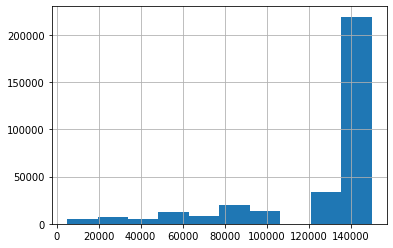

In [59]:
df['kilometer'].hist()

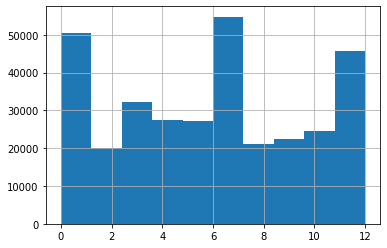

In [60]:
df['registrationmonth'].hist()

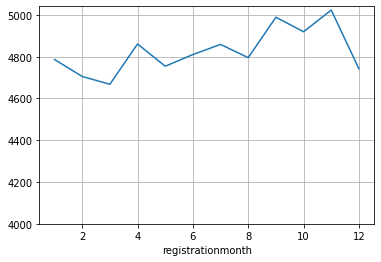

In [61]:
df[df['registrationmonth'] !=0 ].groupby('registrationmonth')['price'].mean().plot(grid=True,ylim=4000)

В общем небольшая корреляция между ценой и месяцем регистрации автомобиля есть

In [62]:
df['fueltype'].value_counts()

petrol      202175
gasoline     94661
lpg           5000
cng            528
hybrid         220
other          137
electric        86
Name: fueltype, dtype: int64

In [63]:
df['fueltype'].isna().sum() / len(df)

0.07225689433838556

In [64]:
fuel_mode = df.groupby(['brand', 'model'])['fueltype'].agg(pd.Series.mode).to_frame()
fuel_mode.columns = ['fuel_mode']
fuel_mode = fuel_mode.reset_index()
fuel_mode[fuel_mode['fuel_mode'].isna()]

,brand,model,fuel_mode


In [65]:
df = df.merge(fuel_mode, how='left')

In [66]:
df['fueltype'] = df['fueltype'].fillna(df.fuel_mode)
df['fueltype'] = df['fueltype'].astype('str')
df['fueltype'].isna().sum()

0

In [67]:
df = df.drop(columns='fuel_mode')
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,0,60437


заполним пропущенные значения в поле "ремонтировалась ли" словом "нет"

In [68]:
df['notrepaired'] = df['notrepaired'].fillna('no')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,no,0,70435
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,yes,0,66954


для обучения почовый индекс и наличие фотографии никой информации не даст, удаляем

In [69]:
df = df.drop(columns=['numberofpictures', 'postalcode'])
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
0,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,yes


добились ненулевых значений

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326391 entries, 0 to 326390
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              326391 non-null  int64  
 1   vehicletype        326391 non-null  object 
 2   registrationyear   326391 non-null  int64  
 3   gearbox            326391 non-null  object 
 4   power              326391 non-null  float64
 5   model              326391 non-null  object 
 6   kilometer          326391 non-null  int64  
 7   registrationmonth  326391 non-null  int64  
 8   fueltype           326391 non-null  object 
 9   brand              326391 non-null  object 
 10  notrepaired        326391 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 29.9+ MB


In [71]:
df.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'registrationmonth', 'fueltype', 'brand', 'notrepaired'],
      dtype='object')

In [72]:
time = df.copy()

посмотрим на зависимость категориальных признаков

In [73]:
encoder = OrdinalEncoder()
col = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
encoder.fit(time[col])
time[col]=encoder.transform(time[col])

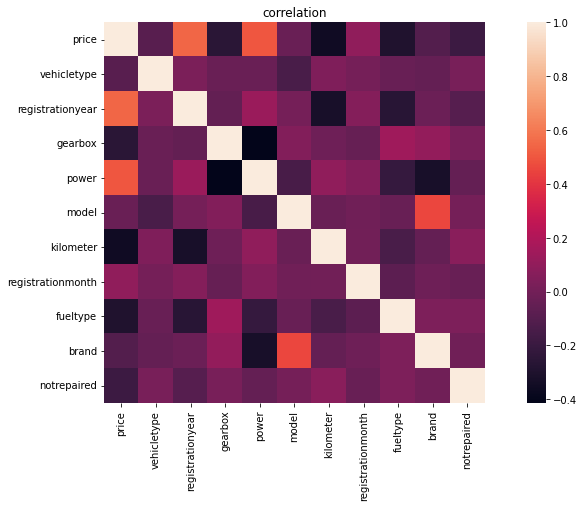

In [74]:
cm = time.corr()
plt.figure(figsize=(15,7))
plt.title('correlation')
sns.heatmap(cm, square=True, fmt='.lf')
plt.show()

сильной корреляции нет. ничего из признаков не будем удалять

## Обучение моделей

В обучении будем использовать 3 модели: LinearRegressor, RandomForestRegressor и LGBMRegressor.

In [75]:
encoder = OrdinalEncoder()
col = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
encoder.fit(time[col])
df[col]=encoder.transform(time[col])
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
0,480,4.0,1993,1.0,90.0,117.0,150000,0,6.0,38.0,0.0
1,18300,2.0,2011,1.0,190.0,30.0,125000,5,2.0,1.0,1.0
2,9800,6.0,2004,0.0,163.0,118.0,125000,8,2.0,14.0,0.0
3,1500,5.0,2001,1.0,75.0,117.0,150000,6,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69.0,102.0,90000,7,2.0,31.0,0.0


выделим целевой и обучающие признаки

In [76]:
x = df.drop('price', axis=1)
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

масштабируем признаки для линейной регрессии

In [77]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_t = scaler.transform(x_train)
x_test_t = scaler.transform(x_test)
x_train_t = pd.DataFrame(x_train_t)
x_train_t.head()

,0,1,2,3,4,5,6,7,8,9
0,0.342037,0.677347,0.49382,-1.109657,-0.070007,-0.771787,-0.497734,0.680137,-0.809604,-0.333133
1,-0.137246,-1.978405,0.49382,0.313243,-0.169302,0.575895,0.589012,0.680137,-0.058212,-0.333133
2,0.342037,-0.650529,0.49382,-1.147102,-0.453000,-1.041324,-1.312793,0.680137,0.467762,3.001801
3,0.342037,0.345378,0.49382,-1.109657,-0.070007,0.575895,-1.584480,0.680137,-0.809604,3.001801
4,-0.137246,0.345378,0.49382,-0.192261,-1.389204,-0.097946,0.045639,0.680137,0.317483,-0.333133


In [78]:
%%time
lr_model = LinearRegression()
lr_mse = cross_val_score(lr_model, x_train_t, y_train, cv = 5, scoring = make_scorer(mean_squared_error))
lr_rmse = (lr_mse**0.5).mean()
print('rmse', lr_rmse)

rmse 2890.5873869426314
CPU times: user 426 ms, sys: 530 ms, total: 956 ms
Wall time: 559 ms


Результаты у LinearRegressor быстрые, но нестоль хороши, судя по ошибке

Методом перебора подберем оптимальные значения для RandomForestRegressor

In [79]:
%%time
best_model_forest = None
rmse_forest = 4000
best_est = 0
best_depth = 0
for est in range(35, 50, 5):
    for depth in range (5, 10, 1):
        model = RandomForestRegressor(random_state=12345, n_estimators=est ,max_depth=depth)
        mse = cross_val_score(model, x_train, y_train, cv = 5, scoring = make_scorer(mean_squared_error))

        rmse = (mse**0.5).mean()
        if rmse < rmse_forest:
            best_model_forest = model
            rmse_forest = rmse
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели:", rmse_forest, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

RMSE наилучшей модели: 1943.1171960606796 Количество деревьев: 45 Максимальная глубина: 9
CPU times: user 10min 2s, sys: 1.04 s, total: 10min 3s
Wall time: 10min 1s


У случайного леса ошибка получше, попробуем LGBMRegressor

In [80]:
%%time
gbm_m = LGBMRegressor(random_state=12345)
mse_gbm = cross_val_score(gbm_m, x_train, y_train, scoring = make_scorer(mean_squared_error), cv = 5, n_jobs=-1)
rmse_gbm = (mse_gbm**0.5).mean()
print('rmse', rmse_gbm)

rmse 1704.2045769608012
CPU times: user 109 ms, sys: 78.1 ms, total: 188 ms
Wall time: 9.32 s


## Анализ моделей

In [81]:
%%time
lr_model = LinearRegression()
lr_model.fit(x_train_t, y_train)
lr_predict = lr_model.predict(x_test_t)
lr_rmse = (mean_squared_error(y_test, lr_predict)**0.5).mean()
print('средняя цена', lr_predict.mean())
print('rmse', lr_rmse)

средняя цена 4574.653829023317
rmse 2887.8836681933094
CPU times: user 60.5 ms, sys: 29 ms, total: 89.5 ms
Wall time: 63 ms


In [82]:
%%time
forest_model = RandomForestRegressor(random_state=12345, n_estimators=45 ,max_depth=9)
forest_model.fit(x_train, y_train)
forest_predict = forest_model.predict(x_test)
forest_rmse = (mean_squared_error(y_test, forest_predict)**0.5).mean()
print('средняя цена', forest_predict.mean())
print('rmse', forest_rmse)

средняя цена 4579.2251840591025
rmse 1936.721235703152
CPU times: user 14.3 s, sys: 132 ms, total: 14.4 s
Wall time: 14.2 s


In [83]:
%%time
gbm_model = LGBMRegressor(random_state=12345)
gbm_model.fit(x_train, y_train)
gbm_predict = gbm_model.predict(x_test)
gbm_rmse = (mean_squared_error(y_test, gbm_predict)**0.5).mean()
print('средняя цена', gbm_predict.mean())
print('rmse', gbm_rmse)

средняя цена 4577.913182403787
rmse 1687.6688175816814
CPU times: user 3.82 s, sys: 36 ms, total: 3.86 s
Wall time: 2 s


В заключение можно сказать об отличной скорости и самой низкой ошибкой в 1687 rmse у LGBMRegressor. На втором месте RandomForestRegressor с ошибкой rmse 1936 (учитывая известные показатели преднастройки). Самый плохой результат оказался у Линейной Регрессии с rmse 2887, но работает быстрее всех.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей